In [165]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
# !pip install mlxtend --upgrade
from mlxtend.evaluate import bias_variance_decomp

from geopy.geocoders import GoogleV3

%matplotlib inline


In [201]:
with open('api_key.txt', 'r') as file:
    key = file.read()

In [202]:
# geolocator = Nominatim(user_agent="geoapiSergani")
geolocator = GoogleV3(api_key=key)

# EDA

In [167]:
def format_date(d):
    """This function returns a datetime object that and a string representation 
    as yyyy-mm. d has to be passed to the function in YYYY.xxxx format."""

    year = str(d).split('.')[0]
    day = str(float(d) - float(year))
    # print('year, day', year, day)
    if day == str(0.0):
        doy = int(1)
    else:
        doy = round(float(day) * 365)  # day of year
    # print('doy', doy)

    date_str = '{}.{}'.format(year, str(doy))
    # print('date string', date_str)

    return datetime.strptime(date_str, '%Y.%j')


In [168]:
def get_location(d, geolocator):
    """This function returns the location string of coordinates when given to it as 'latitude, longitude'."""

    location = geolocator.reverse(d)

    return location

In [169]:
# load csv
df = pd.read_csv(
    '/Users/sergani/Documents/Machine Learning/4 - Machine Learning/house_prices.csv')

# new timedate column
df['X1 TD'] = df.apply(lambda df: format_date(df['X1 transaction date']), axis=1)
# new coordinates column
df['X7 coordinates'] = df['X5 latitude'].astype(str) + ', ' + df['X6 longitude'].astype(str)
# new location column
try:
    df['X8 location'] = df.apply(lambda df: get_location(df['X7 coordinates'], geolocator), axis=1)
except Exception as e:
    print(e)

# inject the new columns
df_td = df['X1 TD']
df_coordinates = df['X7 coordinates']
df.drop(labels=['No', 'X1 TD', 'X7 coordinates'], axis=1,inplace = True)
df.insert(1, 'X1 TD', df_td)
df.insert(7, 'X7 coordinates', df_coordinates)

df.head()


,X1 transaction date,X1 TD,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,X7 coordinates,Y house price of unit area,X8 location
0,2012.917,2012-11-30,32.0,84.87882,10,24.98298,121.54024,"24.98298, 121.54024",37.9,"(No. 42, Minquan Rd, Xindian District, New Tai..."
1,2012.917,2012-11-30,19.5,306.59470,9,24.98034,121.53951,"24.98034, 121.53951",42.2,"(No. 30, Lane 33, Ershizhang Rd, Xindian Distr..."
2,2013.583,2013-08-01,13.3,561.98450,5,24.98746,121.54391,"24.98746, 121.54391",47.3,"(No. 8, Baoqing St, Xindian District, New Taip..."
3,2013.500,2013-07-01,13.3,561.98450,5,24.98746,121.54391,"24.98746, 121.54391",54.8,"(No. 8, Baoqing St, Xindian District, New Taip..."
4,2012.833,2012-10-30,5.0,390.56840,5,24.97937,121.54245,"24.97937, 121.54245",43.1,"(No. 6, Section 3, Beixin Rd, Xindian District..."


In [204]:
print(df['X8 location'].head().values)

[Location(No. 42, Minquan Rd, Xindian District, New Taipei City, Taiwan 231, (24.9830516, 121.5402021, 0.0))
 Location(No. 30, Lane 33, Ershizhang Rd, Xindian District, New Taipei City, Taiwan 231, (24.9804015, 121.5395305, 0.0))
 Location(No. 8, Baoqing St, Xindian District, New Taipei City, Taiwan 231, (24.9872497, 121.5437351, 0.0))
 Location(No. 8, Baoqing St, Xindian District, New Taipei City, Taiwan 231, (24.9872497, 121.5437351, 0.0))
 Location(No. 6, Section 3, Beixin Rd, Xindian District, New Taipei City, Taiwan 231, (24.9793899, 121.5424067, 0.0))]


In [172]:
df.describe(include='all', datetime_is_numeric=True)

,X1 transaction date,X1 TD,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,X7 coordinates,Y house price of unit area,X8 location
count,414.000000,414,414.000000,414.000000,414.000000,414.000000,414.000000,414,414.000000,414
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259,NaN,245
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"24.98203, 121.54348",NaN,"(No. 215, Section 3, Zhongxing Rd, Xindian Dis..."
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,13
mean,2013.148971,2013-02-23 01:16:31.304347904,17.712560,1083.885689,4.094203,24.969030,121.533361,NaN,37.980193,NaN
min,2012.667000,2012-08-30 00:00:00,0.000000,23.382840,0.000000,24.932070,121.473530,NaN,7.600000,NaN
25%,2012.917000,2012-11-30 00:00:00,9.025000,289.324800,1.000000,24.963000,121.528085,NaN,27.700000,NaN
50%,2013.167000,2013-03-02 00:00:00,16.100000,492.231300,4.000000,24.971100,121.538630,NaN,38.450000,NaN
75%,2013.417000,2013-06-01 00:00:00,28.150000,1454.279000,6.000000,24.977455,121.543305,NaN,46.600000,NaN
max,2013.583000,2013-08-01 00:00:00,43.800000,6488.021000,10.000000,25.014590,121.566270,NaN,117.500000,NaN


- Total number of datapoints is 414.
- 259 unique coordinates, 245 unique geolocations.
- All locations in New Taipei City, Taiwan.
- House prices (per unit area) range between 7.6 and 117.5, with an avg of ~38 and std ~13.6.
- Transaction dates range between Aug 2012 and Aug 2013.

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   X1 transaction date                     414 non-null    float64       
 1   X1 TD                                   414 non-null    datetime64[ns]
 2   X2 house age                            414 non-null    float64       
 3   X3 distance to the nearest MRT station  414 non-null    float64       
 4   X4 number of convenience stores         414 non-null    int64         
 5   X5 latitude                             414 non-null    float64       
 6   X6 longitude                            414 non-null    float64       
 7   X7 coordinates                          414 non-null    object        
 8   Y house price of unit area              414 non-null    float64       
 9   X8 location                             414 non-null  

<AxesSubplot: >

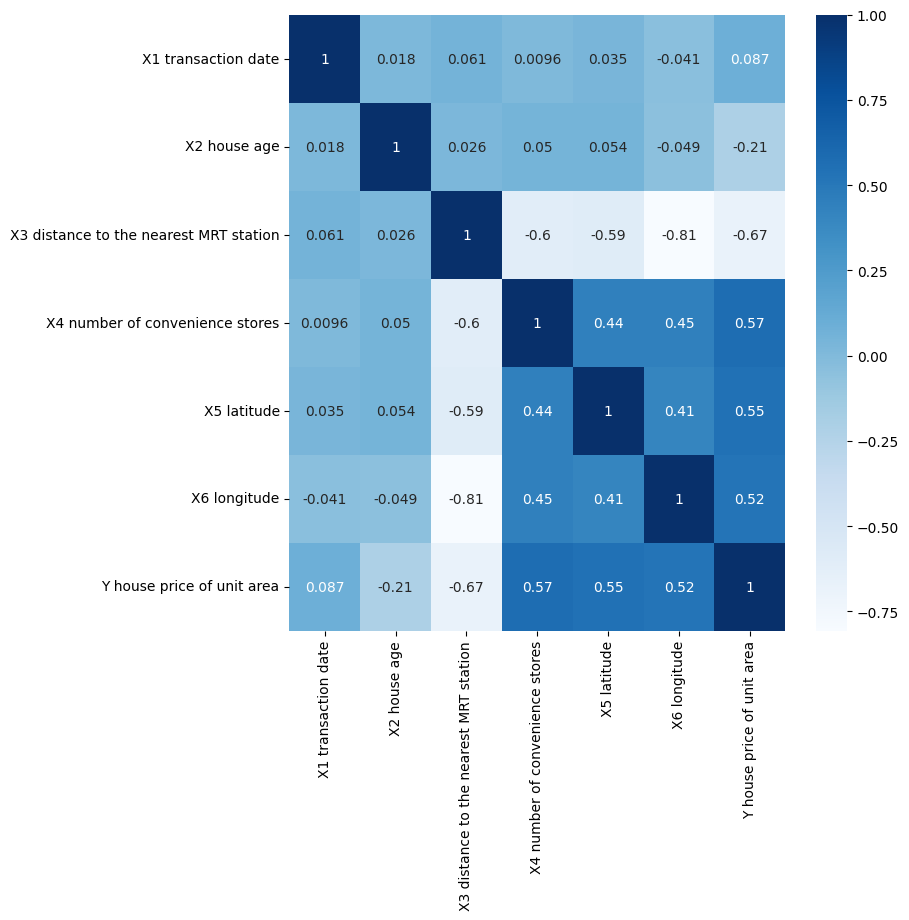

In [174]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))  # plot 6 graphs
sns.heatmap(df.corr(numeric_only=True), cmap="Blues", annot=True)

- There's a higher correlation between house prices and distance from the nearest MRT station, number of close convenience stores, and the house's location than the house's age or when the transaction took place.

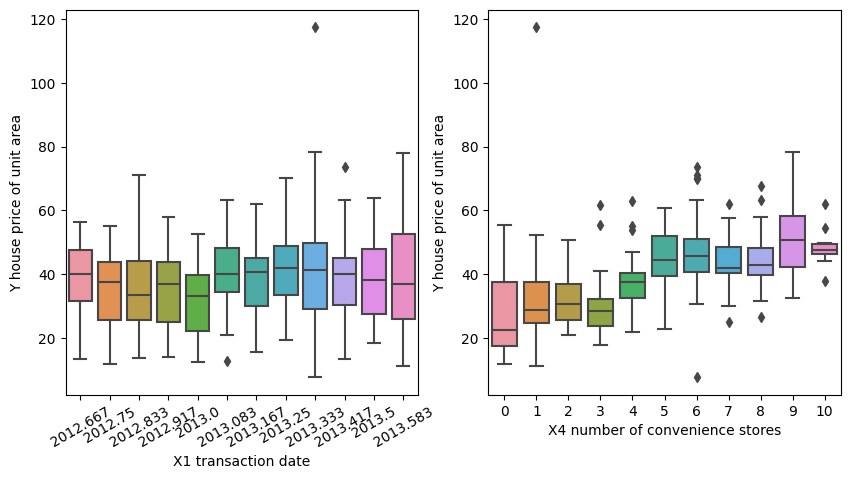

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # plot 2 graphs
ax = sns.boxplot(data=df, x='X1 transaction date',
                 y='Y house price of unit area', ax=axes[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax = sns.boxplot(data=df, x='X4 number of convenience stores',
                 y='Y house price of unit area', ax=axes[1])

* There are very little outliers when looking at house prices per unit area vs the transaction date.
* There's a higher number of outlier datapoints when looking at house prices per unit area vs the number of close convenience stores.

- House prices don't seem to be directly affected by the transaction date when looking at the house's age.
- House prices are clearly higher when houses are close to the MRT station(s).
- House prices are clearly higher when houses are close to more convenience stores.
- Clearly, house prices are greatly affected (and increase) when houses are closer to MRT stations and more convenience stores.
- House prices seem to be more affected by its closeness to MRT stations than number of convenience stores.

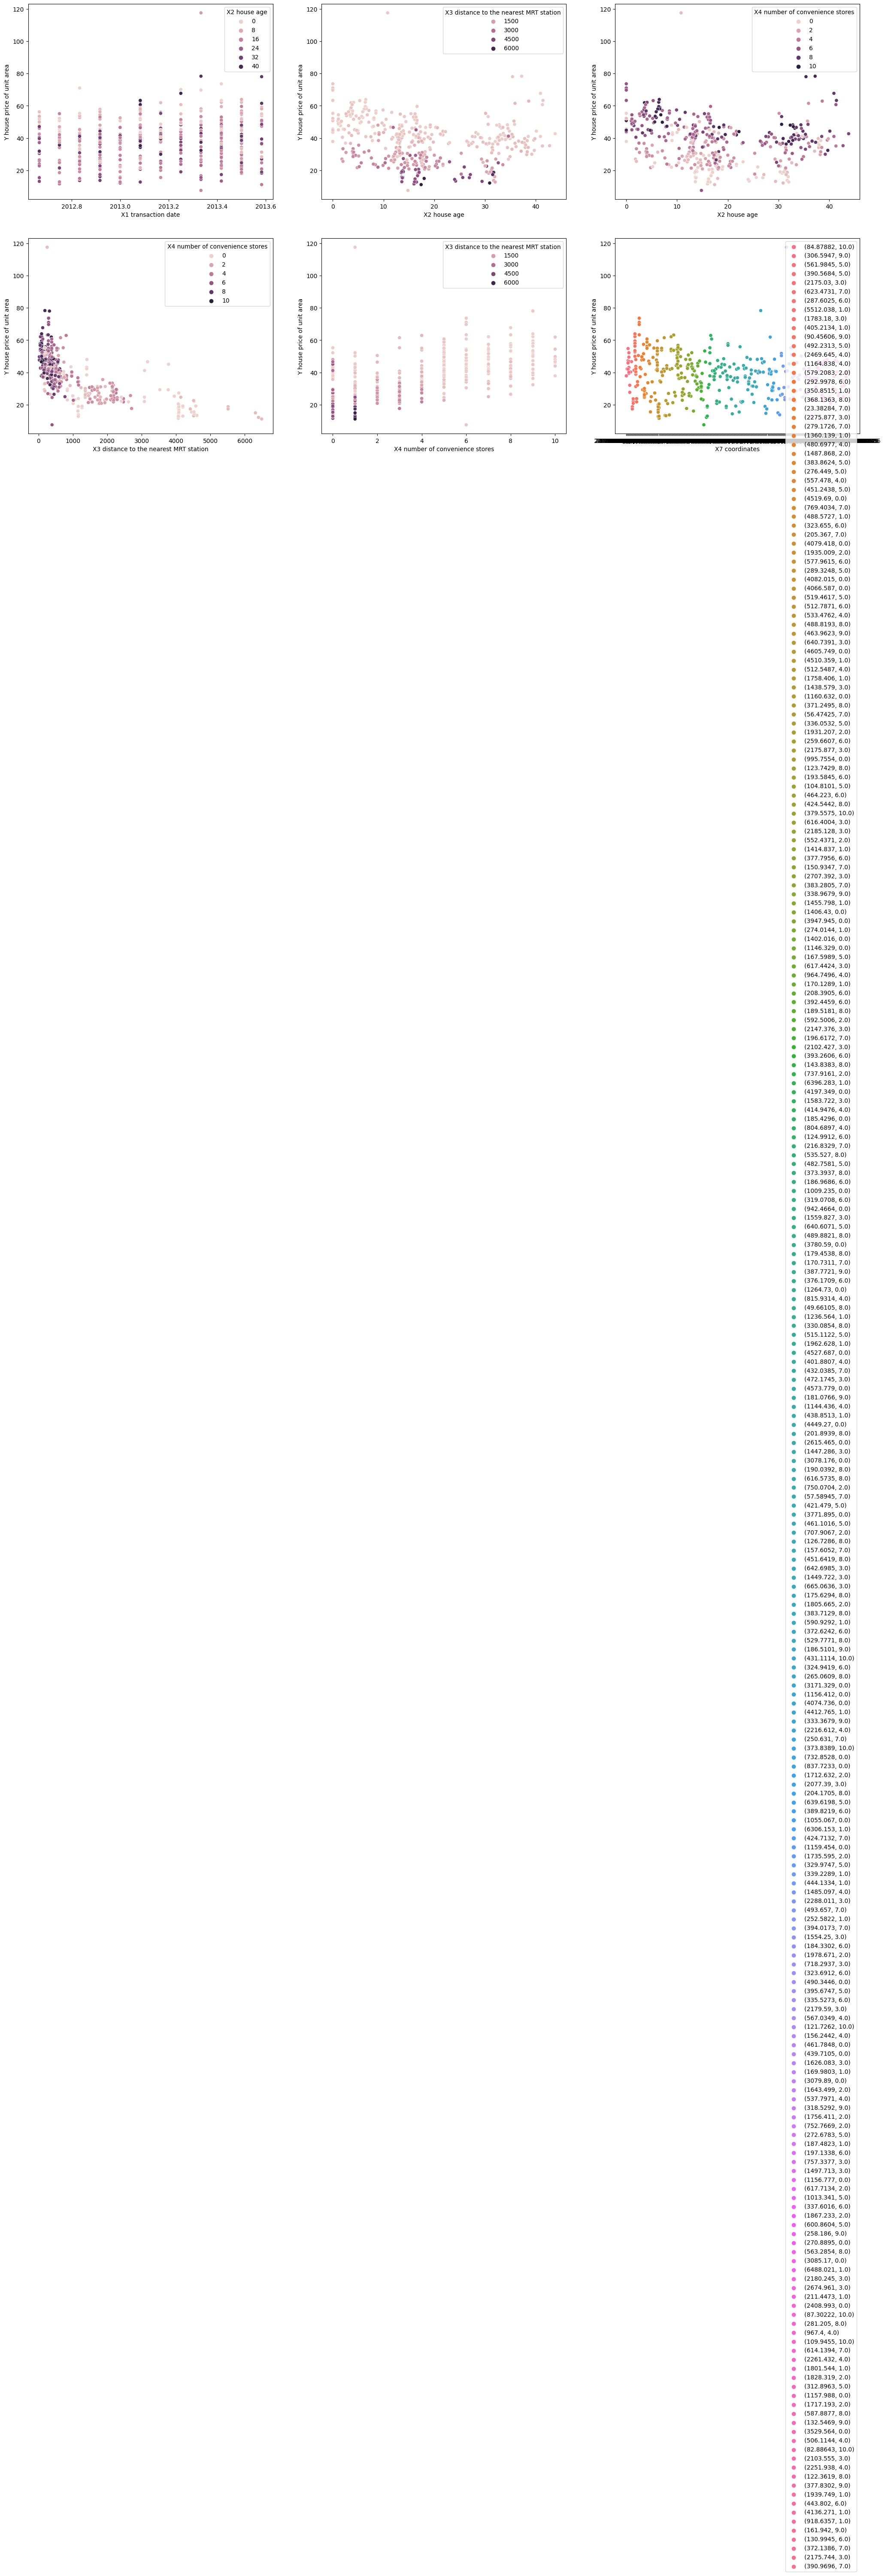

In [205]:
fig, axes = plt.subplots(2, 3, figsize=(25, 13))  # plot 6 graphs
ax = sns.scatterplot(data=df, x='X1 transaction date',
                y='Y house price of unit area', hue='X2 house age', ax=axes[0][0])
ax = sns.scatterplot(data=df, x='X2 house age', y='Y house price of unit area',
                hue='X3 distance to the nearest MRT station', ax=axes[0][1])
ax = sns.scatterplot(data=df, x='X2 house age', y='Y house price of unit area',
                hue='X4 number of convenience stores', ax=axes[0][2])
ax = sns.scatterplot(data=df, x='X3 distance to the nearest MRT station',
                y='Y house price of unit area', hue='X4 number of convenience stores', ax=axes[1][0])
ax = sns.scatterplot(data=df, x='X4 number of convenience stores',
                y='Y house price of unit area', hue='X3 distance to the nearest MRT station', ax=axes[1][1])
ax = sns.scatterplot(data=df, x='X7 coordinates',
                y='Y house price of unit area', hue=df[['X3 distance to the nearest MRT station','X4 number of convenience stores']].apply(tuple, axis=1), ax=axes[1][2])

<AxesSubplot: xlabel='X5 latitude', ylabel='Y house price of unit area'>

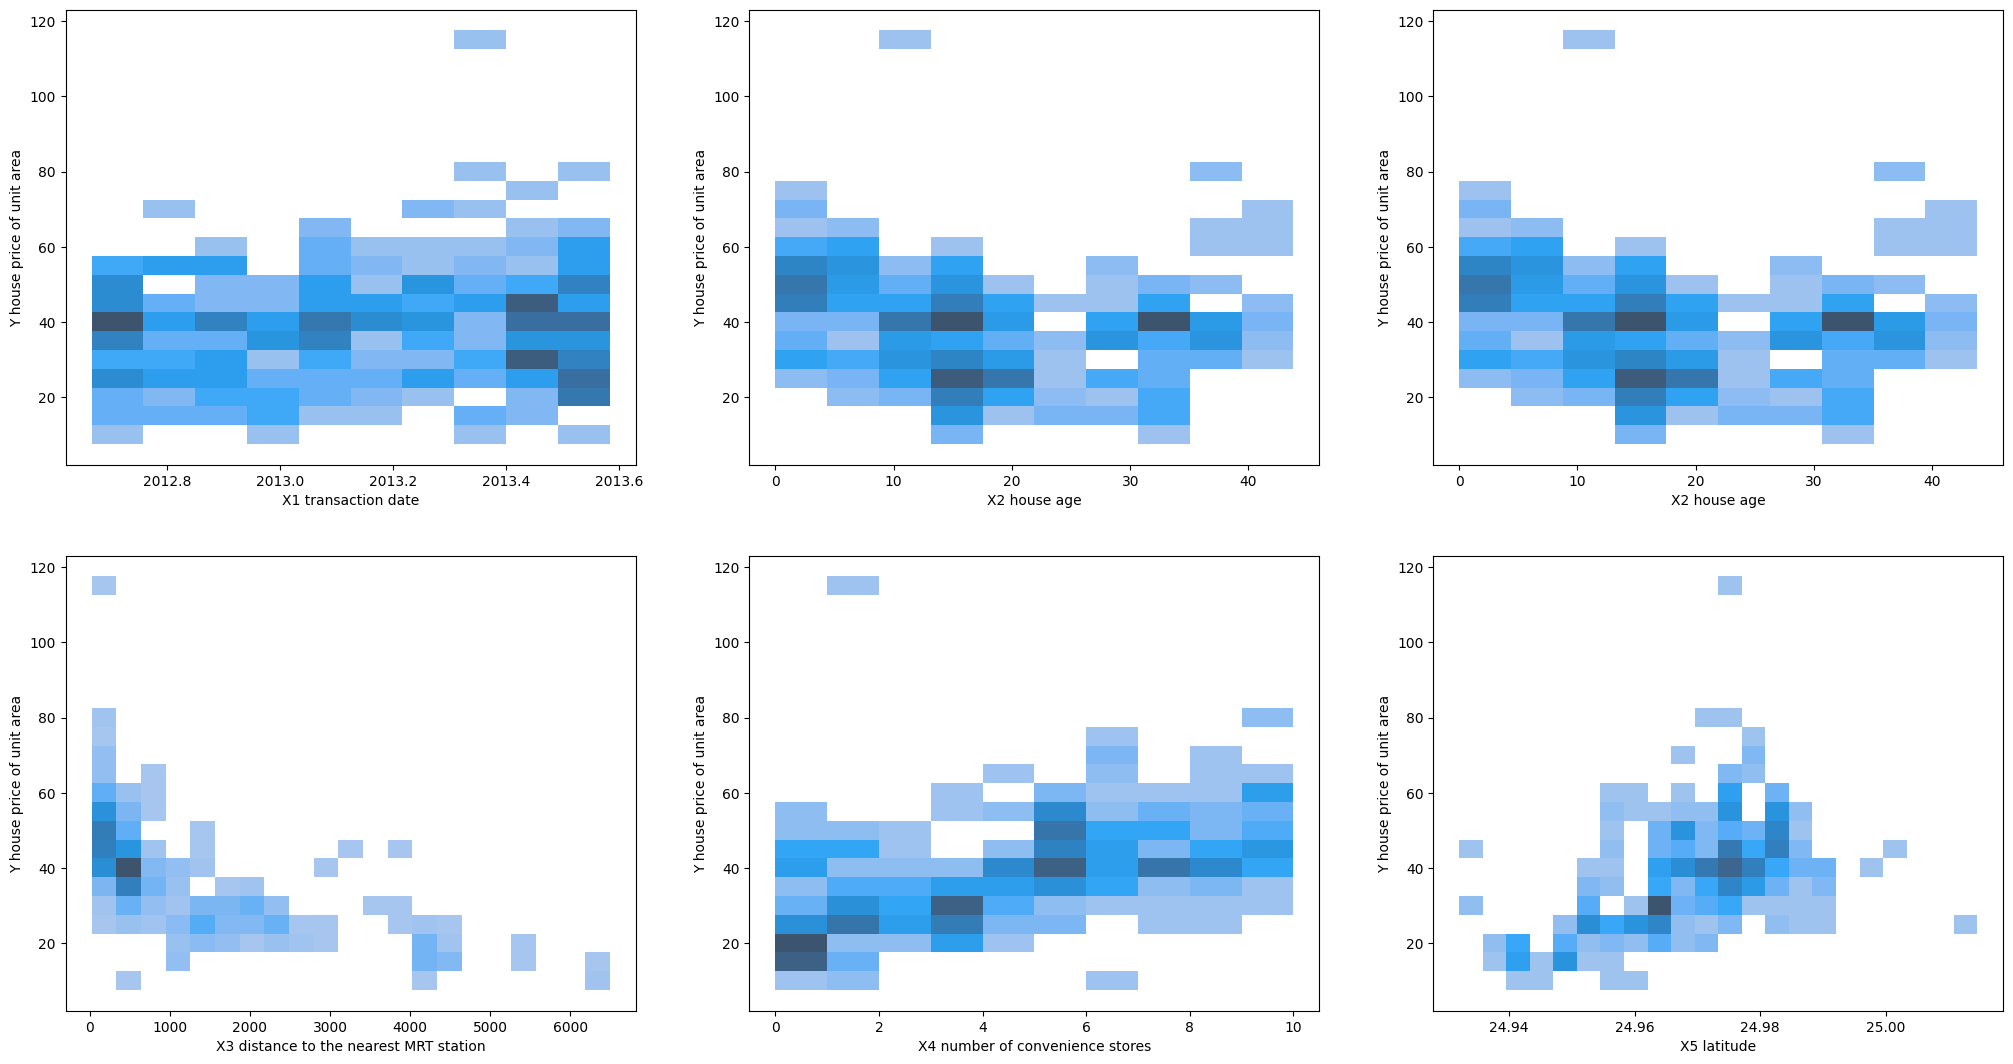

In [177]:
fig, axes = plt.subplots(2, 3, figsize=(25, 13))  # plot 6 graphs
sns.histplot(data=df, x='X1 transaction date',
             y='Y house price of unit area', ax=axes[0][0])
sns.histplot(data=df, x='X2 house age', y='Y house price of unit area',
             ax=axes[0][1])
sns.histplot(data=df, x='X2 house age', y='Y house price of unit area',
             ax=axes[0][2])
sns.histplot(data=df, x='X3 distance to the nearest MRT station',
             y='Y house price of unit area', ax=axes[1][0])
sns.histplot(data=df, x='X4 number of convenience stores',
             y='Y house price of unit area', ax=axes[1][1])
sns.histplot(data=df, x='X5 latitude', y='Y house price of unit area',
             ax=axes[1][2])


## Geoplotting

In [178]:
from plotly.express import scatter_geo
import plotly.graph_objs as go
# import plotly.io


In [210]:
sg = scatter_geo(df, df['X5 latitude'], df['X6 longitude'],
                 hover_data=['Y house price of unit area'], fitbounds='locations',
                 title='House prices per unit area', template='ggplot2')
sg.show()


# Regression

## Single Linear Regression

In [180]:
def linear_regression_model(x, y, x_label, y_label):
    """"This function takes in x and y in a numpy array form, and returns the
    linear regression equation, R2, MSE, and RMSE. It also graphs the whole
    thing.
    """
    model = linear_model.LinearRegression().fit(x, y)

    # Get the intercept (a_0) and coefficient (a_1)
    a_0 = model.intercept_
    a_1 = model.coef_

    # Scoring the prediction accuracy
    y_pred = model.predict(x)

    # R2, MSE and RMSE
    r_score = r2_score(y, y_pred)
    MSE = mean_squared_error(y, y_pred)
    RMSE = np.sqrt(mean_squared_error(y, y_pred))

    print(
        'The linear regression equation is y = {} + {}*x'.format(a_0, a_1[0]))
    print('R2 is {} '.format(r_score))
    print('The mean squared error (MSE) is {}'.format(MSE))
    print('The root mean squared error (RMSE) is {}'.format(RMSE))
    print()

    # Graph
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, y_pred, c='r')
    plt.show()


X1 transaction date:
The linear regression equation is y = -8461.350354321848 + 4.221908398202379*x
R2 is 0.007654606208700954 
The mean squared error (MSE) is 183.27559383805945
The root mean squared error (RMSE) is 13.537931667653647



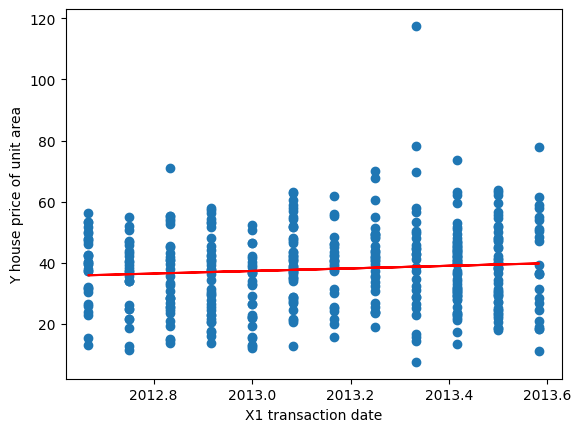

X2 house age:
The linear regression equation is y = 42.43469704626289 + -0.2514884190853454*x
R2 is 0.04433848097791171 
The mean squared error (MSE) is 176.50047403131393
The root mean squared error (RMSE) is 13.285348095978287



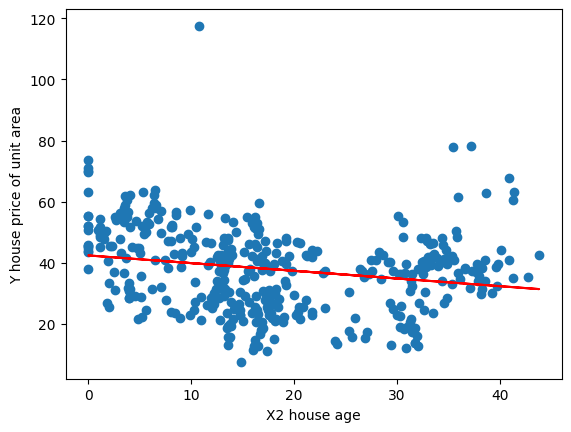

X3 distance to the nearest MRT station:
The linear regression equation is y = 45.851427057774984 + -0.007262051618149456*x
R2 is 0.45375427891826703 
The mean squared error (MSE) is 100.88574959799587
The root mean squared error (RMSE) is 10.044189842789505



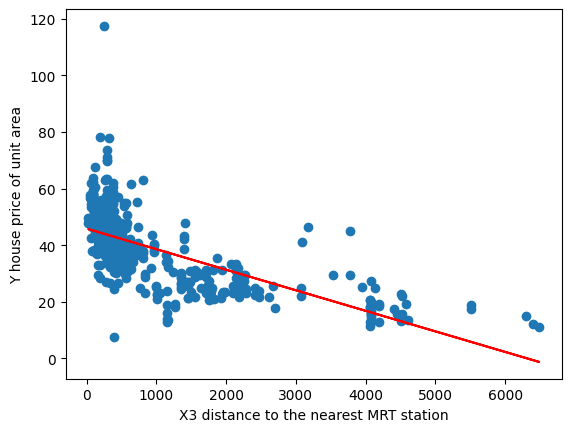

X4 number of convenience stores:
The linear regression equation is y = 27.181104781472424 + 2.637653463404375*x
R2 is 0.32604660851305056 
The mean squared error (MSE) is 124.47199212769486
The root mean squared error (RMSE) is 11.156701668848857



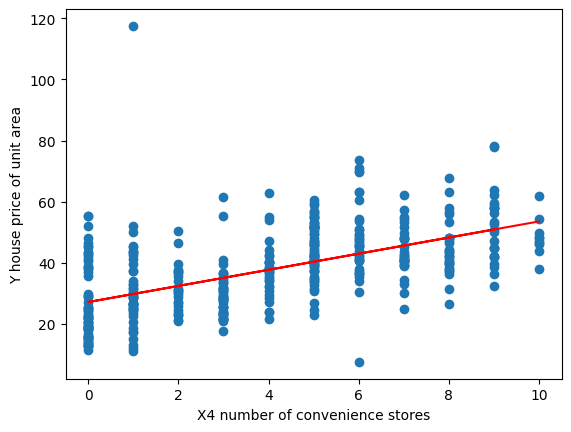

X5 latitude:
The linear regression equation is y = -14917.678090678015 + 598.9683315896224*x
R2 is 0.29845095856969295 
The mean squared error (MSE) is 129.56861389100376
The root mean squared error (RMSE) is 11.382820998812367



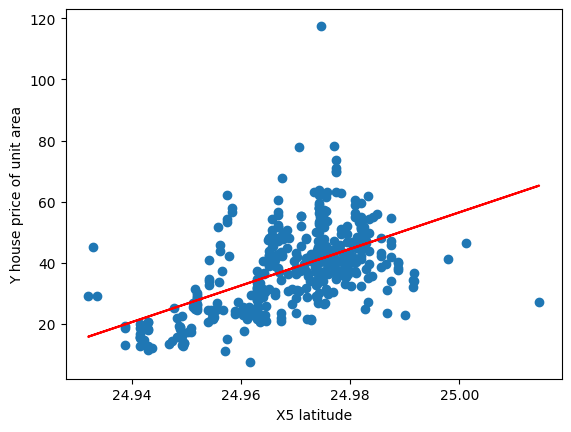

X6 longitude:
The linear regression equation is y = -56345.56858531245 + 463.9347441251707*x
R2 is 0.27382876843836945 
The mean squared error (MSE) is 134.11606939001217
The root mean squared error (RMSE) is 11.580849251674602



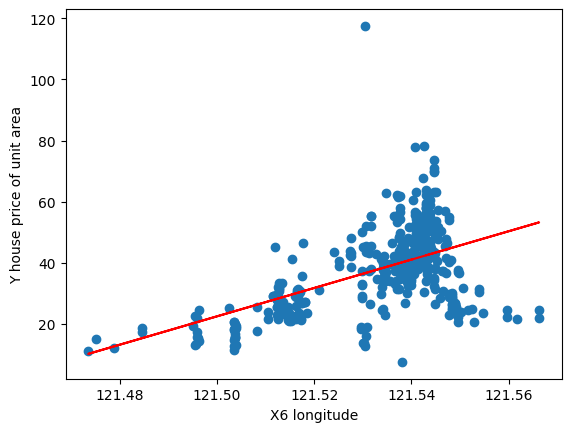

In [181]:
# Set x & y values
for xdata in ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station',
              'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']:
    print('{}:'.format(xdata))
    x, x_label = df[[xdata]].values, list(df[[xdata]].columns)
    y, y_label = df['Y house price of unit area'].values, list(
        df[['Y house price of unit area']].columns)

    linear_regression_model(x, y, x_label[0], y_label[0])


## Multilinear Regression

In [182]:
def mlinear_regression_model(x, y, x_label, y_label):
    """"This function takes in x and y in a numpy array form, and returns the
    linear regression equation, R2, MSE, and RMSE. It also graphs the whole
    thing.

    This function only works with either 2 x variables or 3. In the case of 3 x
    variables there will be no graph.
    """
    model = linear_model.LinearRegression().fit(x, y)

    # Get the intercept (a_0) and coefficients (a_1 / a_2)
    a_0 = model.intercept_
    a_1 = model.coef_[0]
    a_2 = model.coef_[1]

    if len(x_label) == 3:
        a_3 = model.coef_[2]
    else:
        a_3 = None

    # Scoring the prediction accuracy
    y_pred = model.predict(x)

    # R2, MSE and RMSE
    r_score = r2_score(y, y_pred)
    MSE = mean_squared_error(y, y_pred)
    RMSE = np.sqrt(mean_squared_error(y, y_pred))

    if len(x_label) == 2:
        print('The linear regression equation is y = {} + {}*x_1 + {}*x_2'.format(a_0, a_1, a_2))
    else:
        print('The linear regression equation is y = {} + {}*x_1 + {}*x_2 + {}*x_3'.format(a_0, a_1, a_2, a_3))
    print('R2 is {} '.format(r_score))
    print('The mean squared error (MSE) is {}'.format(MSE))
    print('The root mean squared error (RMSE) is {}'.format(RMSE))
    print()

    if len(x_label) == 2:
        # Graph
        fig = plt.figure(figsize=(8, 6), dpi=100).add_subplot(projection='3d')
        # mpl.rcParams['legend.fontsize'] = 12

        # ax = fig.gca()

        fig.view_init(45, 45)

        fig.scatter(x[:, 0], x[:, 1], y)
        fig.plot(x[:, 0], x[:, 1], y_pred, c='y')
        fig.set_xlabel(x_label[0])
        fig.set_ylabel(x_label[1])
        fig.set_zlabel(y_label[0])
        # ax.legend()
        plt.show()
    else:
        return


In [183]:
# Set x & y values
x, x_label = df[['X1 transaction date', 'X2 house age']].values, list(
    df[['X1 transaction date', 'X2 house age']].columns)
y, y_label = df['Y house price of unit area'].values, list(
    df[['Y house price of unit area']].columns)


The linear regression equation is y = -8818.562609725393 + 4.401577477205426*x_1 + -0.2534001870214785*x_2
R2 is 0.05265589225155287 
The mean squared error (MSE) is 174.9643370170149
The root mean squared error (RMSE) is 13.22740855258561



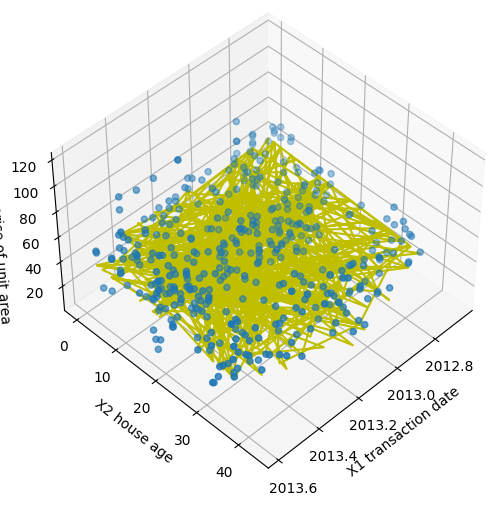

In [184]:
mlinear_regression_model(x, y, x_label, y_label)


In [185]:
# Set x & y values
x, x_label = df[['X3 distance to the nearest MRT station', 'X4 number of convenience stores']].values, list(
    df[['X3 distance to the nearest MRT station', 'X4 number of convenience stores']].columns)
y, y_label = df['Y house price of unit area'].values, list(
    df[['Y house price of unit area']].columns)


The linear regression equation is y = 39.122902690543846 + -0.005578007895607937*x_1 + 1.197599043906736*x_2
R2 is 0.49656835105076846 
The mean squared error (MSE) is 92.97844782201769
The root mean squared error (RMSE) is 9.64253326787197



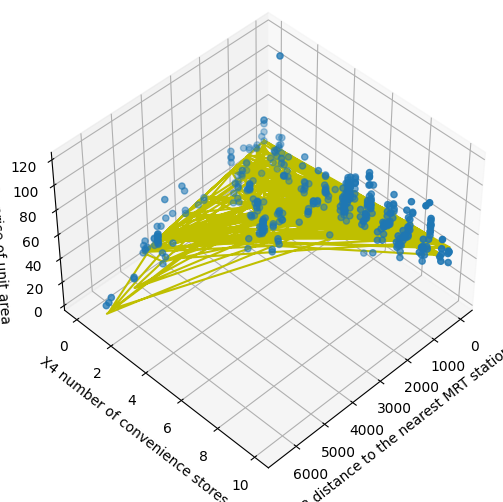

In [186]:
mlinear_regression_model(x, y, x_label, y_label)


In [187]:
# Set x & y values
x, x_label = df[['X5 latitude', 'X6 longitude']].values, list(
    df[['X5 latitude', 'X6 longitude']].columns)
y, y_label = df['Y house price of unit area'].values, list(
    df[['Y house price of unit area']].columns)


The linear regression equation is y = -49531.466479767114 + 436.4852695159899*x_1 + 318.19109178263267*x_2
R2 is 0.40529602245610863 
The mean squared error (MSE) is 109.835471927565
The root mean squared error (RMSE) is 10.480241978483368



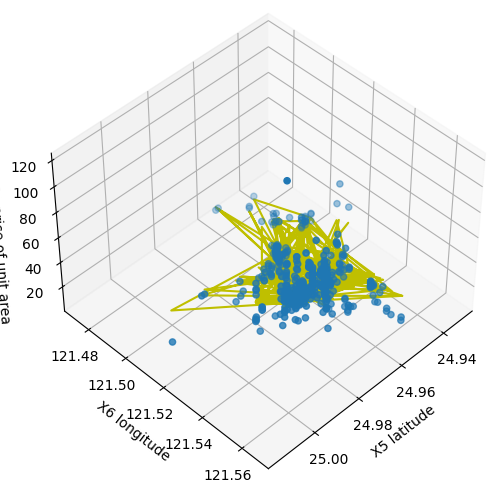

In [188]:
mlinear_regression_model(x, y, x_label, y_label)


## Polynomial Regression

In [189]:
def polynomial_regression_model(x, y, x_label, y_label, deg):
    """"This function takes in x and y in numpy array forms, and returns the
    polynomial regression equation, R2, MSE, and RMSE. This function works with 
    just one x variable.
    """
    # Create the polynomial regression model
    poly_reg = PolynomialFeatures(degree=deg)
    x_poly = poly_reg.fit_transform(x)

    # Create the linear regression model and fit x and y
    lin = linear_model.LinearRegression()
    lin.fit(x, y)

    # Create the linear regression model and fit x_poly and y
    lin2 = linear_model.LinearRegression()
    lin2.fit(x_poly, y)

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # plot 2 graphs
    # Visualising the Linear Regression results
    axes[0].scatter(x, y, color='blue')
    axes[0].plot(x, lin.predict(x), color='red')
    axes[0].set_title('Linear Regression')

    # Visualising the Polynomial Regression results
    axes[1].scatter(x, y, color='blue')
    axes[1].plot(x, lin2.predict(poly_reg.fit_transform(x)), color='red')
    axes[1].set_title('Polynomial Regression')

    # Set the labels
    for ax in axes.flat:
        ax.set(xlabel=x_label, ylabel=y_label)

    plt.show()


X1 transaction date:


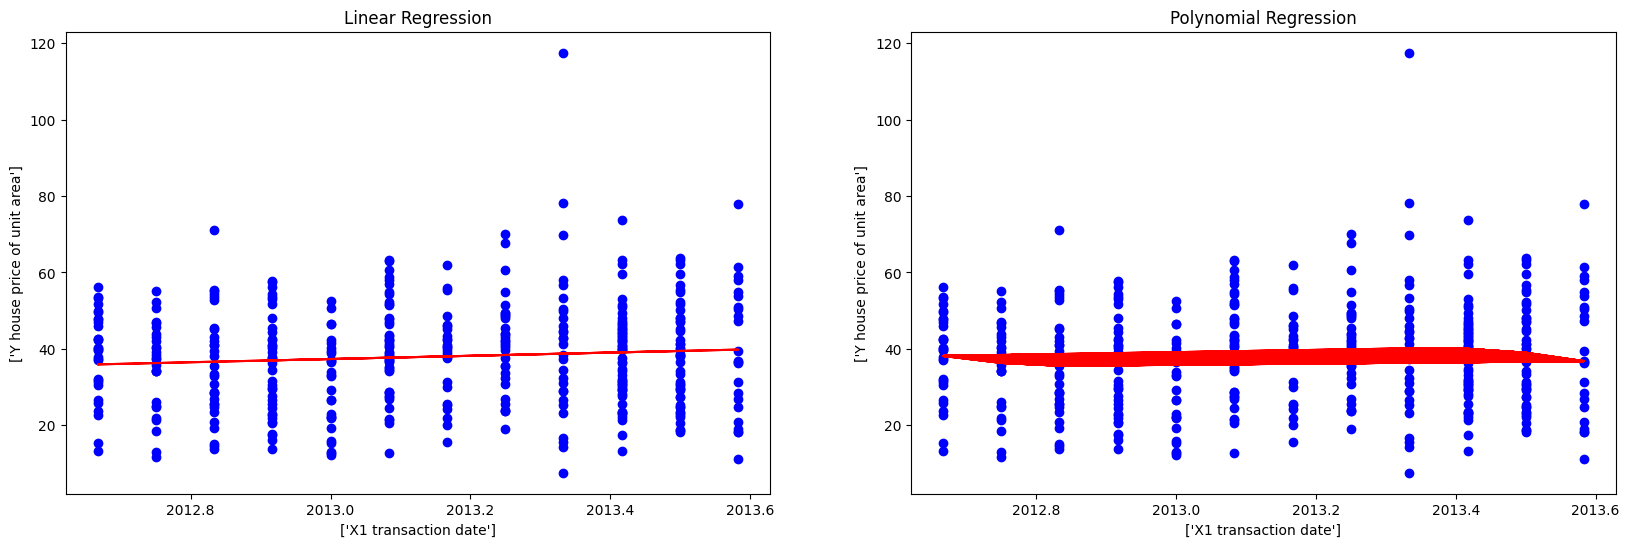

X2 house age:


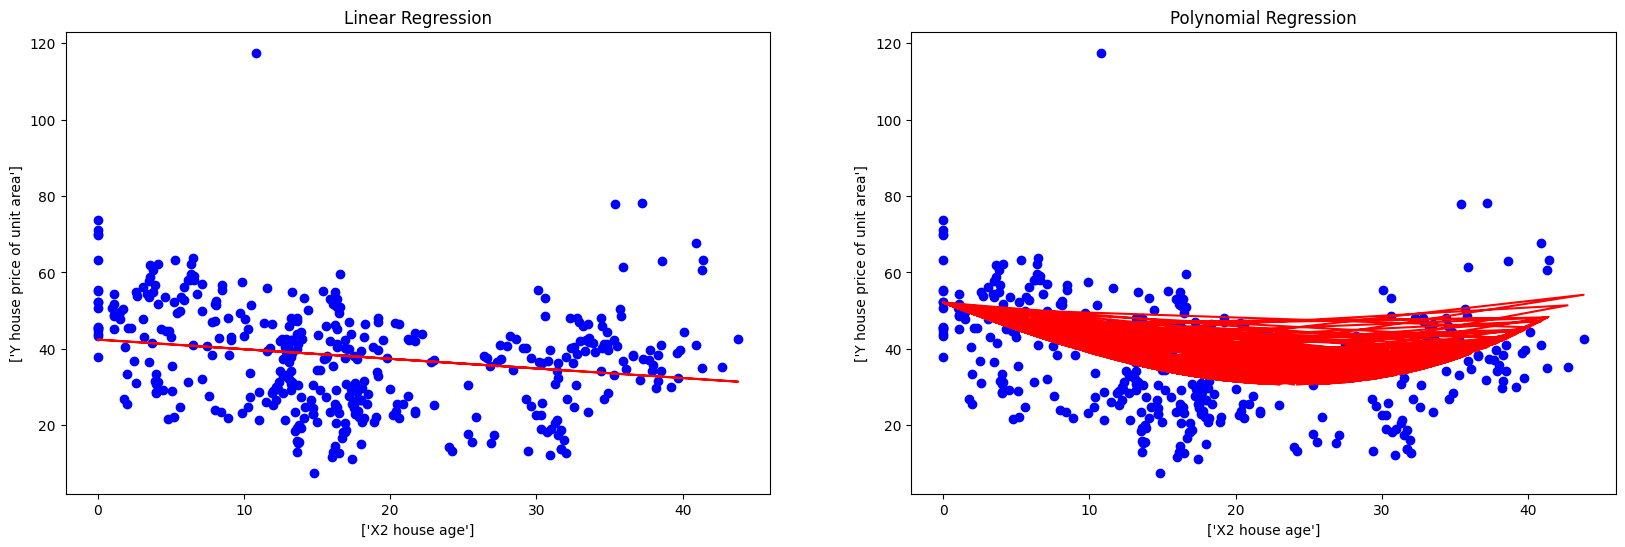

X3 distance to the nearest MRT station:


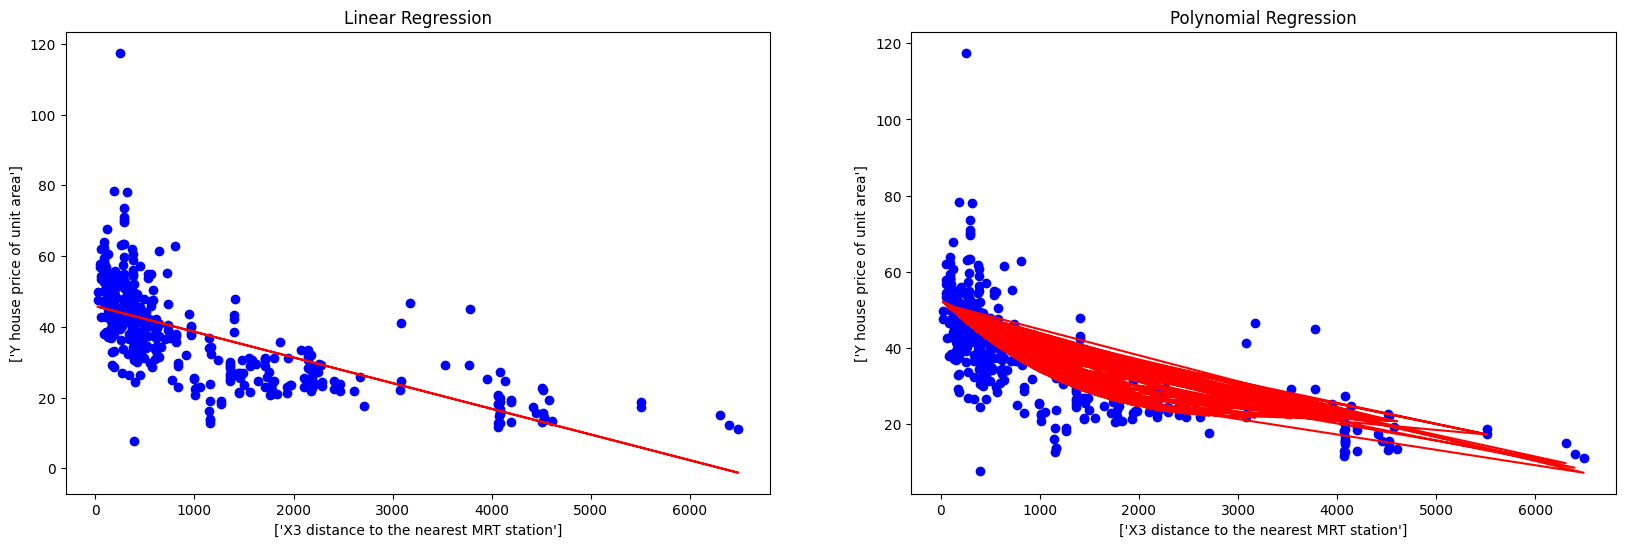

X4 number of convenience stores:


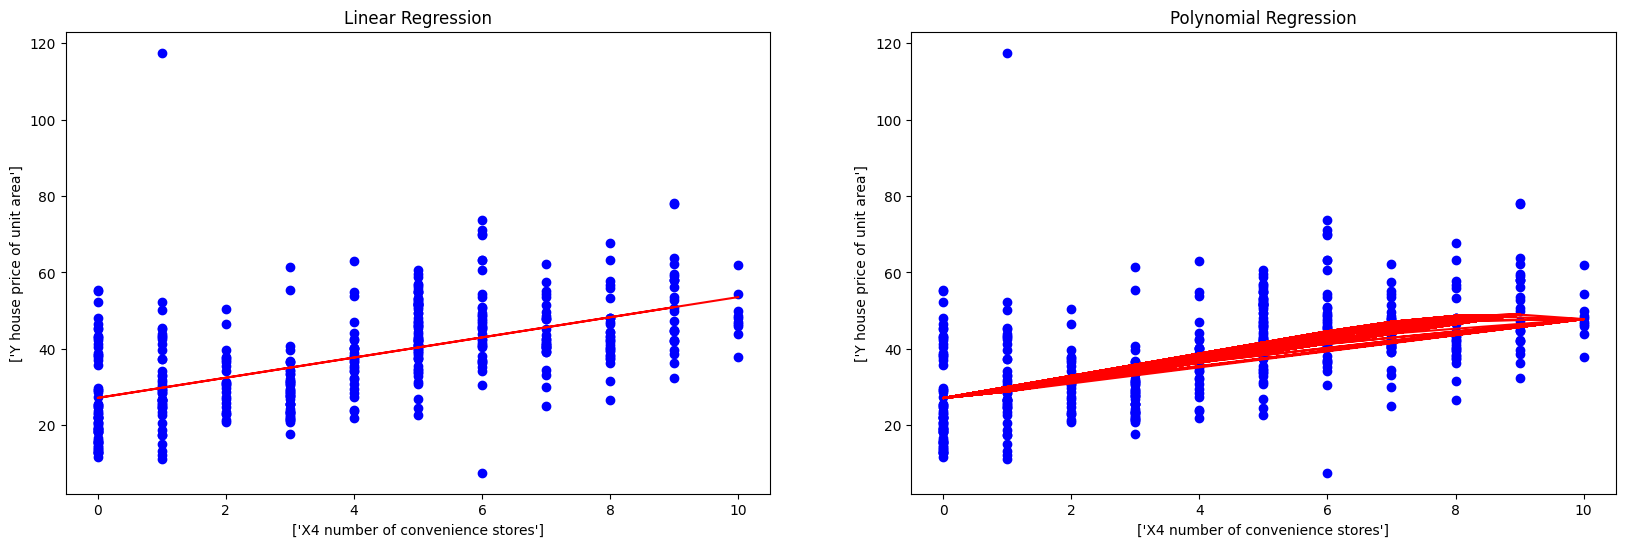

X5 latitude:


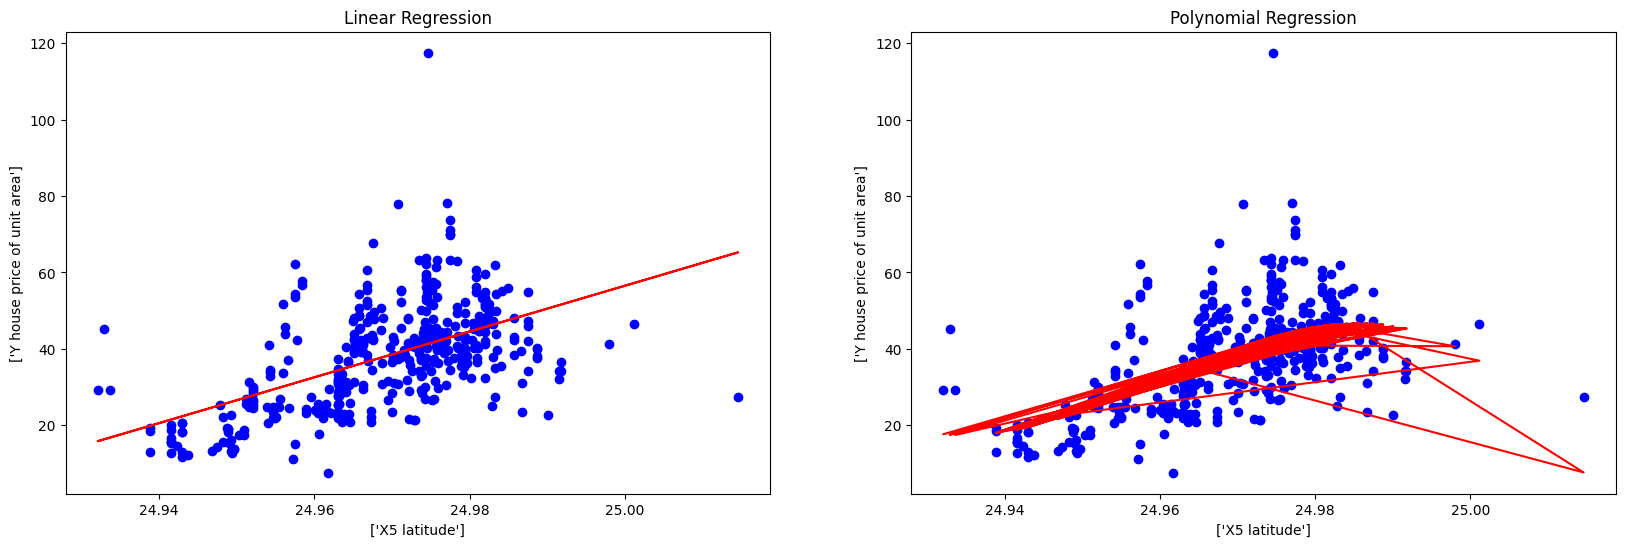

X6 longitude:


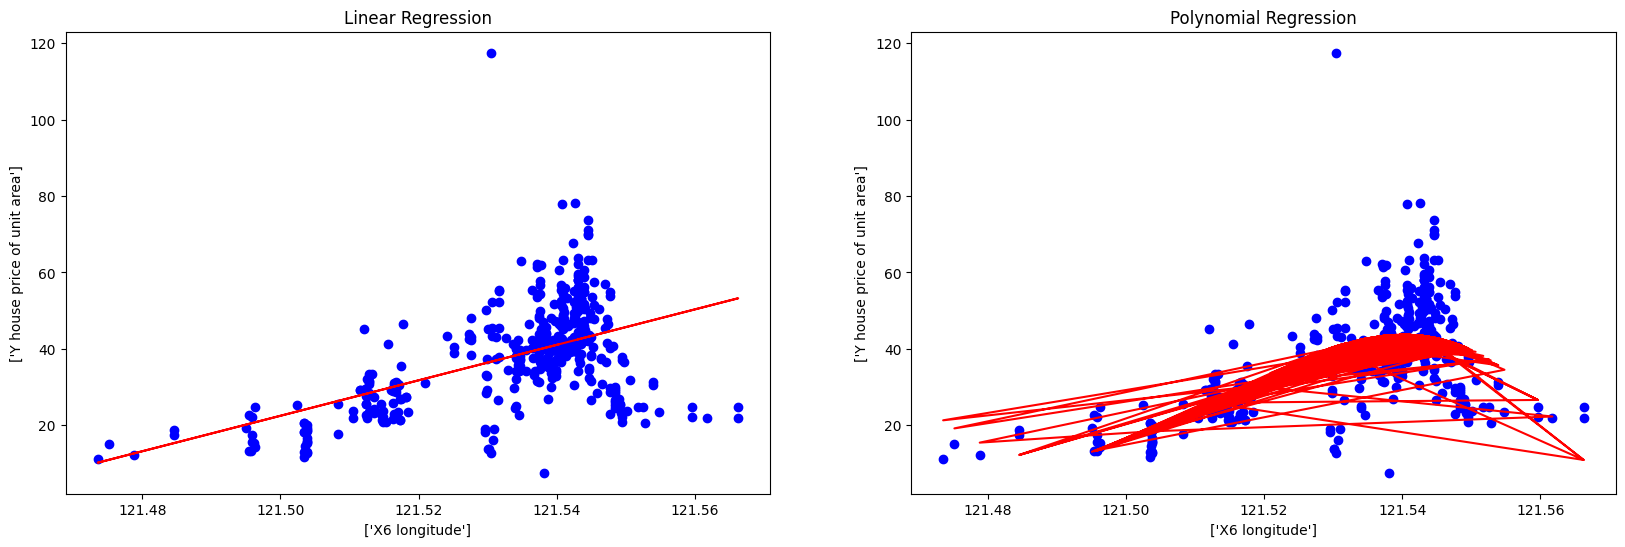

In [190]:
# Set x & y values
for xdata in ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station',
              'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']:
    print('{}:'.format(xdata))
    x, x_label = df[[xdata]].values, list(df[[xdata]].columns)
    y, y_label = df['Y house price of unit area'].values, list(
        df[['Y house price of unit area']].columns)

    polynomial_regression_model(x, y, x_label, y_label, 3)


# Regularization

In [193]:
class RegressionModel():
    def __init__(self, df, ts=0.3, rs=1):
        print('Loading dataframe...')
        self.df = df
        self.x = self.df.drop(
            ['Y house price of unit area', 'X1 TD', 'X7 coordinates', 'X8 location'], axis=1)
        self.y = self.df['Y house price of unit area']

        print('Train/Test splitting...')
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x, self.y, test_size=ts, random_state=rs)
        print('Creating simple linear regression model...')
        self.reg = linear_model.LinearRegression()
        print('Creating L1 regularized linear regression model (Lasso)...')
        self.lasso_reg = linear_model.Lasso(alpha=50, max_iter=100, tol=0.1)
        print('Creating L2 regularized linear regression model (Ridge)...')
        self.ridge_reg = linear_model.Ridge(alpha=50, max_iter=100, tol=0.1)

        print('All three regression models created successfully!')
        print('------------')
        self.fit()
    
    def fit(self):
        print('Fitting the simple linear regression model (R1)...')
        # using .values to suppress warnings
        self.reg.fit(self.x_train.values, self.y_train.values)
        print('Fitting the L1 regularized linear regression model (R2)...')
        self.lasso_reg.fit(self.x_train.values, self.y_train.values)
        print('Fitting the L2 regularized linear regression model (R3)...')
        self.ridge_reg.fit(self.x_train.values, self.y_train.values)

        print('All three models (R1/R2/R3) fitted successfully!')
        print('------------')

    def predict(self, x):
        x = np.array(x).reshape(1, -1)
        reg_pred = self.reg.predict(x)
        lasso_reg_pred = self.lasso_reg.predict(x)
        ridge_reg_pred = self.ridge_reg.predict(x)
        avg_pred = (reg_pred + lasso_reg_pred + ridge_reg_pred) / 3
        print('Using R1, y is predicted to be: {}'.format(str(reg_pred)))
        print('Using R2, y is predicted to be: {}'.format(str(lasso_reg_pred)))
        print('Using R3, y is predicted to be: {}'.format(str(ridge_reg_pred)))
        print('------------')
        print('The average prediction would be: {}'.format(str(avg_pred)))
        print('------------')

    def score(self):
        reg_score = self.reg.score(self.x_test.values, self.y_test.values)
        lasso_reg_score = self.lasso_reg.score(
            self.x_test.values, self.y_test.values)
        ridge_reg_score = self.ridge_reg.score(
            self.x_test.values, self.y_test.values)

        print('R1\'s score is: {}'.format(str(reg_score)))
        print('R2\'s score is: {}'.format(str(lasso_reg_score)))
        print('R3\'s score is: {}'.format(str(ridge_reg_score)))
        print('------------')

    def get_bias_var(self):
        models = {'R1': self.reg, 'R2': self.lasso_reg, 'R3': self.ridge_reg}

        for m in models:
            avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
                models[m], self.x_train.values, self.y_train.values, self.x_test.values, self.y_test.values, loss='mse', num_rounds=5, random_seed=45)
            print('For regression model {}:'.format(m))
            print('++ Average Expected Loss: {}'.format(str(avg_expected_loss)))
            print('++ Average Bias: {}'.format(str(avg_bias)))
            print('++ Average Variance: {}'.format(str(avg_var)))
            print('------------')

    def __str__(self):
        models = {'R1': self.reg, 'R2': self.lasso_reg, 'R3': self.ridge_reg}

        formula = ''
        for m in models:
            formula += 'The linear regression formula for {} is as follows:\n'.format(
                m)
            formula += 'y = '
            formula += str(models[m].intercept_)
            for idx, coef in enumerate(models[m].coef_):
                if coef == 0.0:
                    continue
                if str(coef).startswith('-'):
                    formula += ' - '
                    coef = abs(coef)
                else:
                    formula += ' + '
                formula += '{}(x{})'.format(str(coef), str(idx + 1))
            formula += '\n\n'

            # print('{}:'.format(m))
            # print(formula)
        return formula


In [194]:
reg_model = RegressionModel(df)


Loading dataframe...
Train/Test splitting...
Creating simple linear regression model...
Creating L1 regularized linear regression model (Lasso)...
Creating L2 regularized linear regression model (Ridge)...
All three regression models created successfully!
------------
Fitting the simple linear regression model (R1)...
Fitting the L1 regularized linear regression model (R2)...
Fitting the L2 regularized linear regression model (R3)...
All three models (R1/R2/R3) fitted successfully!
------------


In [195]:
reg_model.predict([2011.15, 23, 2500, 4, 24.98745, 121.52235])

Using R1, y is predicted to be: [26.34659218]
Using R2, y is predicted to be: [27.93516055]
Using R3, y is predicted to be: [26.5052657]
------------
The average prediction would be: [26.92900614]
------------


In [196]:
reg_model.score()

R1's score is: 0.5418646463779593
R2's score is: 0.43847965951243484
R3's score is: 0.5099858138557096
------------


In [197]:
reg_model.get_bias_var()

For regression model R1:
++ Average Expected Loss: 107.16066674118466
++ Average Bias: 106.00159547485156
++ Average Variance: 1.159071266333085
------------
For regression model R2:
++ Average Expected Loss: 129.21109080872074
++ Average Bias: 128.88251733695458
++ Average Variance: 0.3285734717661911
------------
For regression model R3:
++ Average Expected Loss: 113.66985885156028
++ Average Bias: 112.93046062539584
++ Average Variance: 0.7393982261644331
------------


In [198]:
print(reg_model)

The linear regression formula for R1 is as follows:
y = -17471.631848851484 + 4.11573446882316(x1) - 0.19841435147319783(x2) - 0.0037595685057024986(x3) + 1.340981888202782(x4) + 264.17758159539176(x5) + 21.632335063758234(x6)

The linear regression formula for R2 is as follows:
y = 45.27147713973904 - 0.007288794319206096(x3)

The linear regression formula for R3 is as follows:
y = -2546.3543882936797 + 1.2839275146461864(x1) - 0.18428284032859946(x2) - 0.005043607210614995(x3) + 1.431560196128813(x4) + 0.15993721478604994(x5) - 0.01909547654859105(x6)


